In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import os
import numpy as np
import cv2
import scipy
from tqdm import tqdm
from models import resnet50
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
img_path = '../demo/image/train_run0_ung_61_02_c0007_frame0070.jpg'
save_path = '../demo/smpl_param'
pretrained_model_path = '../logs/12_28_21_12_/model.ckpt-3'
img_size = 224
batch_size = 1
pose_params = 72

img_list = [os.path.basename(img_path)]
img_path = os.path.dirname(img_path)

In [3]:
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
input_size = (batch_size, img_size, img_size, 3)
images_pl = tf.placeholder(tf.float32, shape=input_size)
out, _ = resnet50(images_pl, pose_params, is_training=False, reuse=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# init = tf.global_variables_initializer()
# sess.run(init)
saver = tf.train.Saver()
print('Restoring checkpoint %s..' % pretrained_model_path)
saver.restore(sess, pretrained_model_path)

Restoring checkpoint ../logs/12_28_21_12_/model.ckpt-3..
INFO:tensorflow:Restoring parameters from ../logs/12_28_21_12_/model.ckpt-3


In [6]:
for img_name in tqdm(img_list):
#     image = cv2.imread(os.path.join(img_path, img_name))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = image_preprocessing(image, img_size)
#     image = image * 1.0 / 255

#     print(image)
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Add batch dimension: 1 x D x D x 3
#     image = tf.expand_dims(image, axis = 0)
#     image = image.eval(session = sess)
    image = np.loadtxt('../0.txt')
    image = image.reshape(224, 224, 3)
    image = np.expand_dims(image, 0)
    theta = sess.run(out, feed_dict={images_pl: image})
    theta = np.round(theta.reshape((-1, 24, 3)), 6)
    print(theta[0, 0, :])

100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

[37455.918 23579.541 13147.517]


In [8]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.layers.python.layers.initializers import variance_scaling_initializer


In [ ]:
def resnet50(x, nums, is_training=True, reuse=False):
    """
    Resnet v2-50
    Assumes input is [batch, height_in, width_in, channels]!!
    Input:
    - x: N x H x W x 3
    - reuse: bool->True if test

    Outputs:
    - cam: N x 3
    - Pose vector: N x 72
    - Shape vector: N x 10
    - variables: tf variables
    """
    from tensorflow.contrib.slim.python.slim.nets import resnet_v2
    with tf.name_scope("Resnet", [x]):
        with slim.arg_scope(resnet_v2.resnet_arg_scope()):
            net, end_points = resnet_v2.resnet_v2_50(       # shape=(N, 1, 1, 2048)
                x,
                num_classes=None,
                is_training=is_training,
                reuse=reuse,
                scope='resnet_v2_50')
            net = tf.squeeze(net, axis=[1, 2])              # shape=(N, 2048)
            net = slim.fully_connected(
                net, 
                num_outputs=nums,
                activation_fn=None, 
                trainable=is_training,
                reuse=reuse,
                scope='fc')
    variables = tf.contrib.framework.get_variables('resnet_v2_50')
    return net, variables


# cv2.copyMakeBorder

In [22]:
img_name = img_list[0]
image1 = cv2.imread(os.path.join(img_path, img_name))
image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image3 = image_preprocessing(image2, img_size)

28 28 0 0


In [23]:
image = image2
size = img_size
h, w = image.shape[0], image.shape[1]
m = max(w, h)
ratio = size / m
new_w, new_h = int(ratio * w), int(ratio * h)
resized = cv2.resize(image, (new_w, new_h))
target_h = size
target_w = size
top = (target_h - new_h) // 2
bottom = (target_h - new_h) // 2
if top + bottom + h < target_h:
    bottom += 1
left = (target_w - new_w) // 2
right = (target_w - new_w) // 2
if left + right + w < target_w:
    right += 1
pad_image = cv2.copyMakeBorder(
    resized, top, bottom, left, right, cv2.BORDER_REPLICATE)

In [32]:
resized.shape

(168, 224, 3)

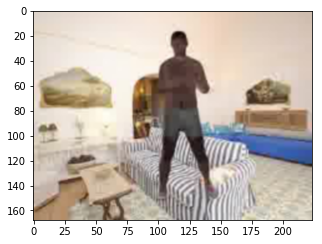

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.imshow(resized,interpolation='bicubic')

In [40]:
t = cv2.copyMakeBorder(resized,28,28,0,0,cv2.BORDER_REPLICATE)

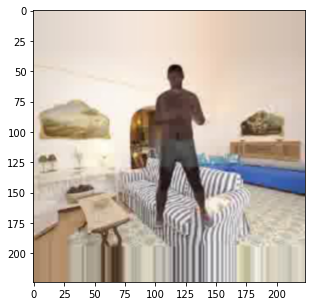

In [41]:
plt.figure(figsize=(5,5))
plt.imshow(t,interpolation='bicubic')